# Phân Loại TDE MALLORN - Huấn Luyện Mô Hình LightGBM

**Mục tiêu:** Train mô hình LightGBM với:
- **Hyperparameter tuning** với 5-fold cross-validation
- **Class imbalance handling** thông qua scale_pos_weight
- **Threshold optimization** để maximize F1 score
- **Feature importance analysis** để hiểu các features quan trọng nhất

**Lý do chọn LightGBM:**
- Xử lý tốt class imbalance với scale_pos_weight
- Nhanh và hiệu quả với nhiều features (~294 features)
- Built-in regularization (L1, L2)
- Feature importance giúp interpretability

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, classification_report, roc_auc_score)
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Features

Đọc train_features.csv và test_features.csv đã được tạo từ bước Feature Engineering.

In [4]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

print(f"Training samples: {len(train_features)}")
print(f"Test samples: {len(test_features)}")
print(f"TDE ratio: {train_features['target'].mean():.4f}")
print(f"Number of features: {len(train_features.columns) - 2}")

Training samples: 3043
Test samples: 7135
TDE ratio: 0.0486
Number of features: 294


## 2. Chuẩn Bị Dữ Liệu

Tách features và target, đảm bảo train và test có cùng feature columns.

In [5]:
exclude_cols = ['object_id', 'target', 'Z_err', 'z_relative_err']
feature_cols = [c for c in train_features.columns if c not in exclude_cols]

X = train_features[feature_cols].values
y = train_features['target'].values

for col in feature_cols:
    if col not in test_features.columns:
        test_features[col] = 0

X_test = test_features[feature_cols].values

print(f"Feature matrix shape: {X.shape}")
print(f"Test matrix shape: {X_test.shape}")
print(f"Number of features: {len(feature_cols)}")

Feature matrix shape: (3043, 294)
Test matrix shape: (7135, 294)
Number of features: 294


## 3. Feature Scaling

Sử dụng StandardScaler để chuẩn hóa features (mean=0, std=1). Điều này giúp mô hình học tốt hơn và ổn định hơn.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("Features scaled with StandardScaler")

Features scaled with StandardScaler


## 4. Tính Class Weights

Tính `scale_pos_weight` = n_negative / n_positive để xử lý class imbalance.
Với tỉ lệ ~19.56:1, mô hình sẽ weight TDE samples cao hơn để cân bằng.

In [7]:
n_neg = np.sum(y == 0)
n_pos = np.sum(y == 1)
scale_pos_weight = n_neg / n_pos

print(f"\nClass distribution:")
print(f"  Non-TDE (0): {n_neg} ({100*n_neg/len(y):.1f}%)")
print(f"  TDE (1): {n_pos} ({100*n_pos/len(y):.1f}%)")
print(f"  Imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"\nUsing scale_pos_weight = {scale_pos_weight:.2f}")


Class distribution:
  Non-TDE (0): 2895 (95.1%)
  TDE (1): 148 (4.9%)
  Imbalance ratio: 19.56:1

Using scale_pos_weight = 19.56


## 5. LightGBM Hyperparameter Search

Thực hiện grid search với 5-fold cross-validation để tìm hyperparameters tốt nhất.

**Tham số được tune:**
- `n_estimators`: Số lượng trees (300, 500, 800)
- `learning_rate`: Tốc độ học (0.01, 0.03, 0.05)
- `max_depth`: Độ sâu tối đa của tree (6, 8, 10)
- `num_leaves`: Số lượng lá trên mỗi tree (31, 63)

**Lưu ý:** Quá trình này mất ~10-15 phút do cần test 54 combinations với 5-fold CV.

In [8]:
print("="*60)
print("Hyperparameter search with 5-fold CV...")
print("="*60)

param_grid = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [6, 8, 10],
    'num_leaves': [31, 63],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_params = None
results = []

total_combinations = (len(param_grid['n_estimators']) * 
                     len(param_grid['learning_rate']) * 
                     len(param_grid['max_depth']) * 
                     len(param_grid['num_leaves']))
print(f"Testing {total_combinations} parameter combinations...\n")

combo_idx = 0
for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for max_d in param_grid['max_depth']:
            for n_leaves in param_grid['num_leaves']:
                combo_idx += 1
                
                params = {
                    'objective': 'binary',
                    'metric': 'binary_logloss',
                    'boosting_type': 'gbdt',
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'num_leaves': n_leaves,
                    'min_child_samples': 20,
                    'subsample': 0.8,
                    'subsample_freq': 1,
                    'colsample_bytree': 0.8,
                    'reg_alpha': 0.1,
                    'reg_lambda': 0.1,
                    'scale_pos_weight': scale_pos_weight,
                    'random_state': 42,
                    'n_jobs': -1,
                    'verbose': -1
                }
                
                model = lgb.LGBMClassifier(**params)
                
                cv_scores = []
                for train_idx, val_idx in cv.split(X_scaled, y):
                    model.fit(X_scaled[train_idx], y[train_idx])
                    val_pred = model.predict(X_scaled[val_idx])
                    cv_scores.append(f1_score(y[val_idx], val_pred))
                
                mean_f1 = np.mean(cv_scores)
                std_f1 = np.std(cv_scores)
                
                results.append({
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'num_leaves': n_leaves,
                    'mean_f1': mean_f1,
                    'std_f1': std_f1
                })
                
                if mean_f1 > best_f1:
                    best_f1 = mean_f1
                    best_params = params.copy()
                    print(f"[{combo_idx}/{total_combinations}] New best F1: {mean_f1:.4f} (+/- {std_f1:.4f})")
                    print(f"    n_est={n_est}, lr={lr}, max_d={max_d}, leaves={n_leaves}")

print(f"\nBest CV F1: {best_f1:.4f}")
print(f"Best params: n_est={best_params['n_estimators']}, lr={best_params['learning_rate']}, "
      f"max_d={best_params['max_depth']}, leaves={best_params['num_leaves']}")

Hyperparameter search with 5-fold CV...
Testing 54 parameter combinations...

[1/54] New best F1: 0.5371 (+/- 0.0635)
    n_est=300, lr=0.01, max_d=6, leaves=31
[7/54] New best F1: 0.5384 (+/- 0.0505)
    n_est=300, lr=0.03, max_d=6, leaves=31
[8/54] New best F1: 0.5407 (+/- 0.0531)
    n_est=300, lr=0.03, max_d=6, leaves=63
[12/54] New best F1: 0.5547 (+/- 0.0580)
    n_est=300, lr=0.03, max_d=10, leaves=63

Best CV F1: 0.5547
Best params: n_est=300, lr=0.03, max_d=10, leaves=63


## 6. Train Final Model với Best Parameters

Sử dụng hyperparameters tốt nhất để train mô hình trên toàn bộ training set.

In [9]:
print("\n" + "="*60)
print("Training final model with best parameters...")
print("="*60)

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_scaled, y)

print("Final model trained!")
print(f"Number of trees: {final_model.n_estimators}")
print(f"Number of features: {final_model.n_features_}")


Training final model with best parameters...
Final model trained!
Number of trees: 300
Number of features: 294


## 7. Cross-Validation Evaluation

Đánh giá performance trên toàn bộ training set với cross-validation predictions.

In [10]:
print("\nPerforming full cross-validation evaluation...")

cv_proba = cross_val_predict(final_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
cv_preds_default = (cv_proba >= 0.5).astype(int)

print(f"\nCV Results (default threshold=0.5):")
print(f"  F1 Score: {f1_score(y, cv_preds_default):.4f}")
print(f"  Precision: {precision_score(y, cv_preds_default):.4f}")
print(f"  Recall: {recall_score(y, cv_preds_default):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y, cv_proba):.4f}")


Performing full cross-validation evaluation...

CV Results (default threshold=0.5):
  F1 Score: 0.5560
  Precision: 0.7204
  Recall: 0.4527
  ROC-AUC: 0.9421


## 8. Threshold Optimization

Tìm threshold tối ưu để maximize F1 score thay vì dùng default threshold=0.5.

**Lý do:** Với class imbalance, threshold 0.5 thường không tối ưu cho F1. Chúng ta cần tìm điểm cân bằng tốt nhất giữa precision và recall.

In [11]:
print("\n" + "="*60)
print("Optimizing threshold for maximum F1 score...")
print("="*60)

thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for thresh in thresholds:
    preds = (cv_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y, preds))
    precision_scores.append(precision_score(y, preds, zero_division=0))
    recall_scores.append(recall_score(y, preds, zero_division=0))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_optimized = f1_scores[best_idx]
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]

print(f"\nOptimal threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_optimized:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")


Optimizing threshold for maximum F1 score...

Optimal threshold: 0.330
Best F1 Score: 0.5735
Precision: 0.6290
Recall: 0.5270


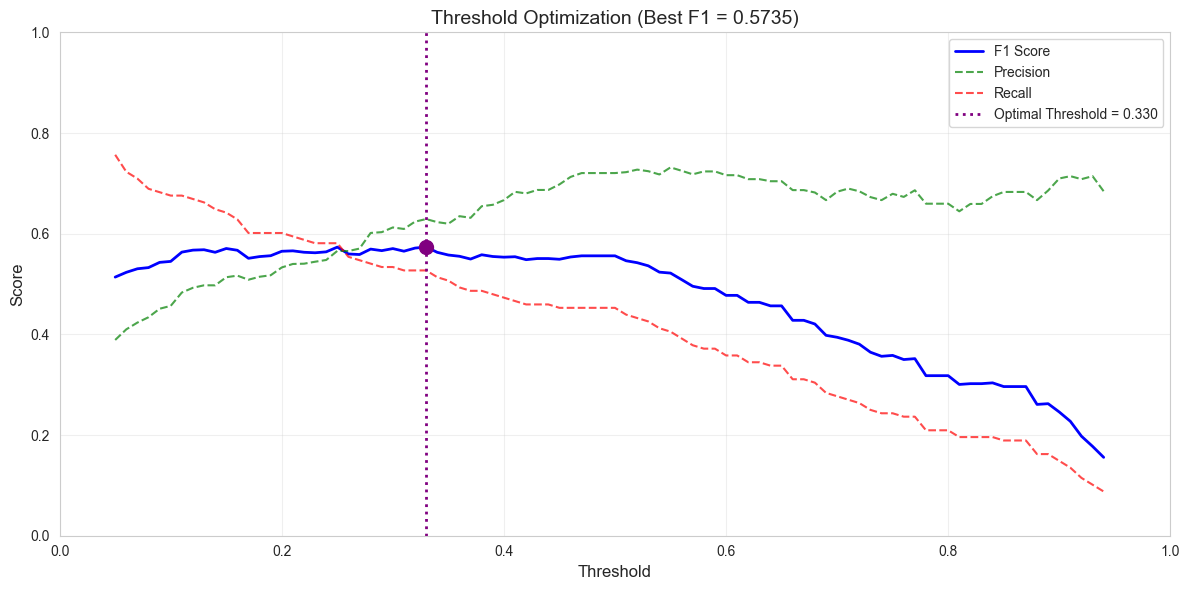

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1 Score')
ax.plot(thresholds, precision_scores, 'g--', linewidth=1.5, alpha=0.7, label='Precision')
ax.plot(thresholds, recall_scores, 'r--', linewidth=1.5, alpha=0.7, label='Recall')
ax.axvline(best_threshold, color='purple', linestyle=':', linewidth=2, 
           label=f'Optimal Threshold = {best_threshold:.3f}')
ax.scatter([best_threshold], [best_f1_optimized], color='purple', s=100, zorder=5)

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Threshold Optimization (Best F1 = {best_f1_optimized:.4f})', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Confusion Matrix

Phân tích chi tiết các loại prediction đúng/sai với optimal threshold.


Classification Report (optimized threshold):
              precision    recall  f1-score   support

     Non-TDE       0.98      0.98      0.98      2895
         TDE       0.63      0.53      0.57       148

    accuracy                           0.96      3043
   macro avg       0.80      0.76      0.78      3043
weighted avg       0.96      0.96      0.96      3043



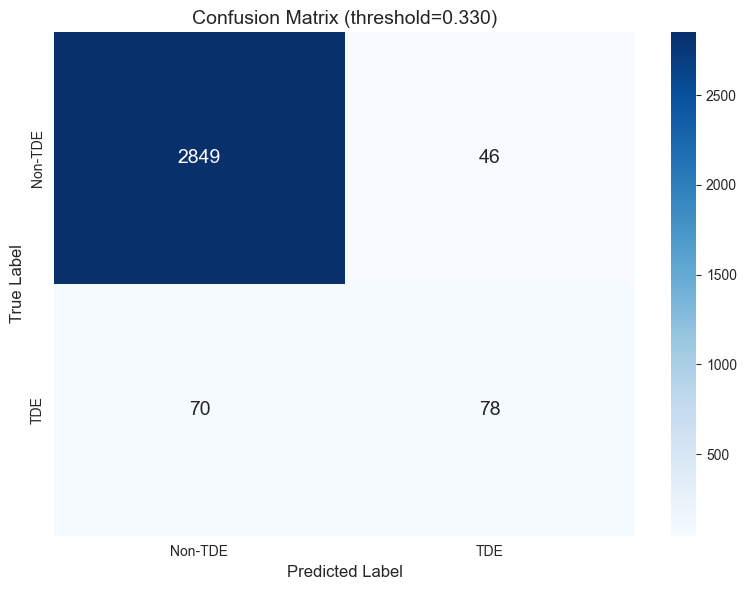


Confusion Matrix Details:
  True Negatives: 2849
  False Positives: 46
  False Negatives: 70
  True Positives: 78


In [13]:
best_preds = (cv_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, best_preds)

print("\nClassification Report (optimized threshold):")
print(classification_report(y, best_preds, target_names=['Non-TDE', 'TDE']))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-TDE', 'TDE'],
            yticklabels=['Non-TDE', 'TDE'],
            annot_kws={'size': 14})
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title(f'Confusion Matrix (threshold={best_threshold:.3f})', fontsize=14)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Details:")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives: {tp}")

## 10. Feature Importance Analysis

Phân tích features nào quan trọng nhất cho việc phân loại TDE.

**Kỳ vọng:** Color features (đặc biệt liên quan đến u-band) và temporal features (duration) sẽ có importance cao.


Top 30 Most Important Features:
            feature  importance
                  Z         128
   peak_time_spread         112
       i_decay_rate         110
     peak_delay_g_r         100
       g_decay_rate          97
         r_flux_p25          96
     g_det_duration          92
        r_flux_skew          88
     r_det_duration          87
     color_peak_r_i          76
        u_time_span          74
       r_decay_rate          71
     color_peak_u_g          71
detection_time_span          68
        g_rise_time          66
         u_flux_p90          66
         r_flux_p10          61
         g_flux_min          61
        r_rise_rate          60
          i_err_std          60
          r_err_std          60
         g_trend_r2          59
          u_err_std          58
     i_det_duration          57
        u_flux_skew          56
          u_snr_max          56
     u_cadence_mean          56
        i_time_span          55
       z_decay_rate          54
       

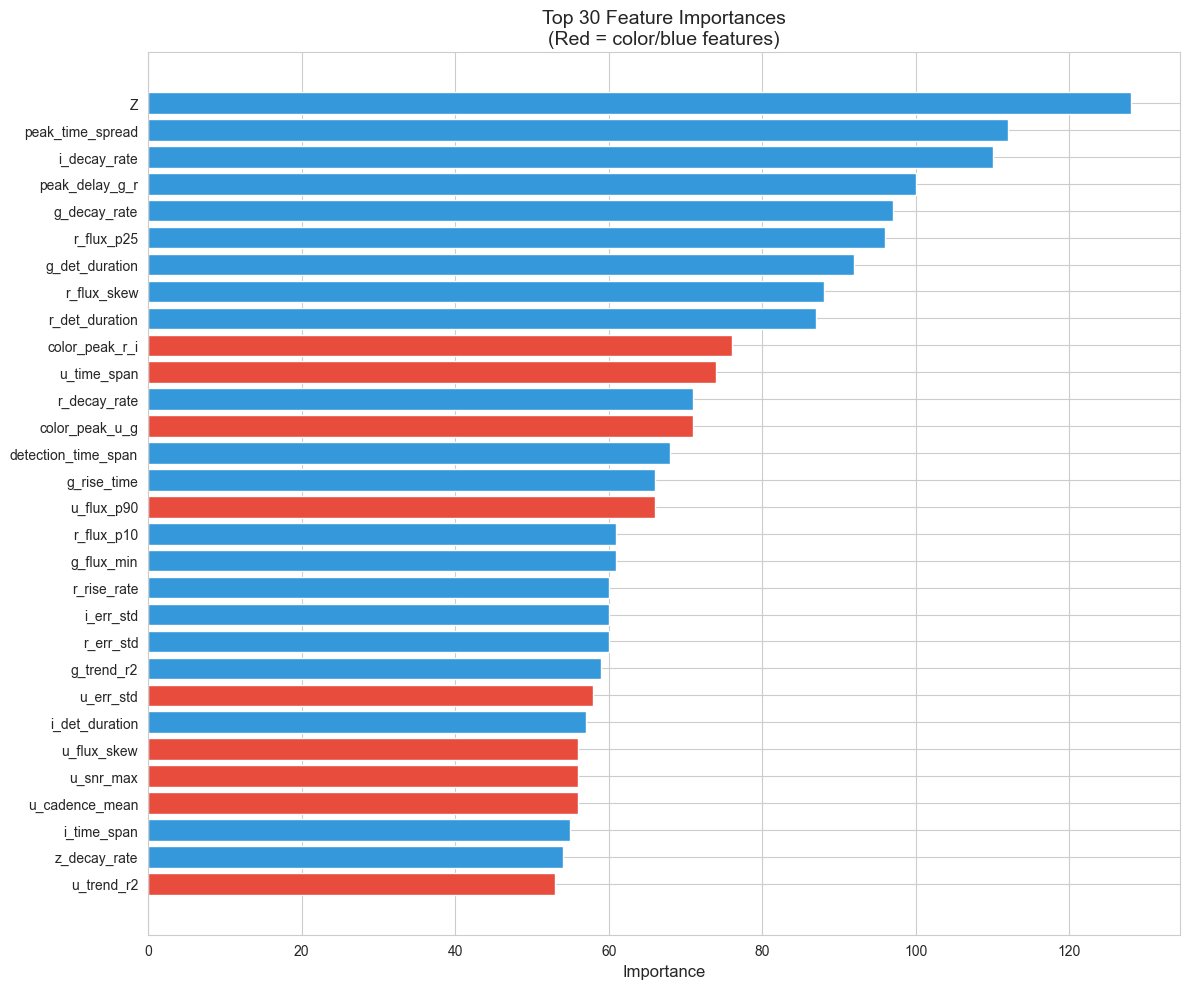

In [14]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 10))
top_n = 30
top_features = feature_importance.head(top_n)

colors = ['#e74c3c' if 'color' in f or 'blue' in f or 'u_' in f[:2] 
          else '#3498db' for f in top_features['feature']]

ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importances\n(Red = color/blue features)', fontsize=14)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Lưu Model và Artifacts

Lưu mô hình, scaler, và các thông tin cần thiết để sử dụng trong bước prediction.

In [15]:
joblib.dump(final_model, 'lgb_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

model_info = {
    'best_threshold': best_threshold,
    'best_f1': best_f1_optimized,
    'best_precision': best_precision,
    'best_recall': best_recall,
    'roc_auc': roc_auc_score(y, cv_proba),
    'scale_pos_weight': scale_pos_weight,
    'feature_cols': feature_cols,
    'best_params': best_params
}
joblib.dump(model_info, 'model_info.joblib')

feature_importance.to_csv('feature_importance.csv', index=False)

results_df = pd.DataFrame(results).sort_values('mean_f1', ascending=False)
results_df.to_csv('hyperparam_search_results.csv', index=False)

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)
print(f"\nBest Performance:")
print(f"  F1 Score: {best_f1_optimized:.4f}")
print(f"  Precision: {best_precision:.4f}")
print(f"  Recall: {best_recall:.4f}")
print(f"  ROC-AUC: {model_info['roc_auc']:.4f}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"\nSaved files:")
print(f"  - lgb_model.joblib")
print(f"  - scaler.joblib")
print(f"  - model_info.joblib")
print(f"  - feature_importance.csv")
print(f"  - hyperparam_search_results.csv")
print(f"\nNext: Run 03_prediction_submission.ipynb")
print("="*60)


MODEL TRAINING COMPLETE

Best Performance:
  F1 Score: 0.5735
  Precision: 0.6290
  Recall: 0.5270
  ROC-AUC: 0.9421
  Optimal Threshold: 0.330

Saved files:
  - lgb_model.joblib
  - scaler.joblib
  - model_info.joblib
  - feature_importance.csv
  - hyperparam_search_results.csv

Next: Run 03_prediction_submission.ipynb
